##Load Boston housing dataset

In [ ]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


##Normalizing the data

In [ ]:
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

##Model definition

In [ ]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))

  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

  return model

##K-fold validation

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples :]], axis=0)
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i + 1) * num_val_samples :]], axis=0)

  model = build_model()
  model.fit(partial_train_data, partial_train_targets, batch_size=1, epochs=num_epochs, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)

  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


##Save validation logs at each fold

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples :]], axis=0)
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i + 1) * num_val_samples :]], axis=0)

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, batch_size=1, epochs=num_epochs, verbose=0, validation_data=(val_data, val_targets))
  mae_history = history.history['val_mae']

  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


##Build history of successive mean K-fold validation scores

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

##Plot validation scores

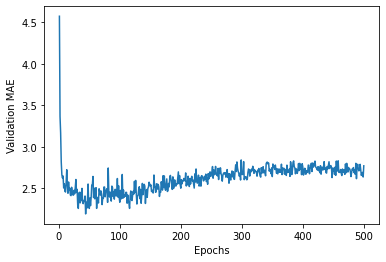

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Plot validation scores, excluding first 10

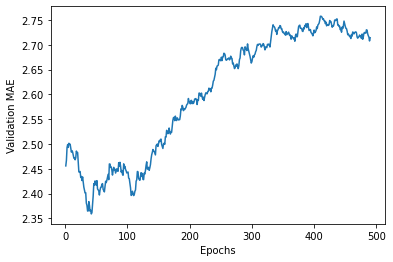

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)

  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

##Train final model

In [ ]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 17.8412 - mae: 2.7843
